In [18]:
!pip install -r requirements.txt
!pip uninstall -y tinarm
!pip install -e ../.

  Cloning https://github.com/TinArmEngineering/tinarm.git (to revision 0.1.81) to /private/var/folders/s5/09ndf2214qb_308ln1n6gfm40000gn/T/pip-req-build-5fhaja1k
  Running command git clone --filter=blob:none --quiet https://github.com/TinArmEngineering/tinarm.git /private/var/folders/s5/09ndf2214qb_308ln1n6gfm40000gn/T/pip-req-build-5fhaja1k
  Running command git checkout -q 95326bba5f50040358d1e4c697986c1457bd751f
  Resolved https://github.com/TinArmEngineering/tinarm.git to commit 95326bba5f50040358d1e4c697986c1457bd751f
  Preparing metadata (setup.py) ... done
  Created wheel for tinarm: filename=tinarm-0.1-py3-none-any.whl size=7253 sha256=e09898d70edf3e6e2a50b91e90fd8acaef7f23e19f8677be5cabe426d8d64907
  Stored in directory: /private/var/folders/s5/09ndf2214qb_308ln1n6gfm40000gn/T/pip-ephem-wheel-cache-eacb0dzm/wheels/b5/3e/f1/78975b6840059f1f22cfabad54abc26bd24ff9224d419ec7e4
Successfully built tinarm
  Attempting uninstall: tinarm
    Found existing installation: tinarm 0.1
   

In [48]:
import matplotlib.pyplot as plt
import pint
# from tinarm import NameQuantityPair
# from tinarm import Quantity 
from tinarm import Job
from tinarm import Machine
from tinarm.api import JOB_STATUS
from tinarm import Api

import logging
import time
import requests
import uuid
import random
import yaml
import pandas as pd
import pint_pandas
import numpy as np


In [20]:

LOGGING_LEVEL = logging.INFO
STATUS_JOB = {value:key for key,value in JOB_STATUS.items()}

In [21]:

### Configure Logging
logger = logging.getLogger()
logger.setLevel(LOGGING_LEVEL)
#logger.info(f"tinarm version {tinarm.__version__}")
logger.info(f"pint_pandas version {pint_pandas.__version__}")

q = pint_pandas.PintType.ureg
q.setup_matplotlib()

2024-03-12 00:54:04,854 - NoJobId - INFO - Martins-MacBook-Air.local - 138153749.py-><module>() - pint_pandas version 0.5


Log in to Tin Arm Engineering's machine solver, and under profile, retrieve your API key. 
Do not commit your API key to a repository, and consider it like a password.  A good way to keep it out of this code base is to use a configuation file, or environment variable. We will want other things cofigured too, so let's use a yaml file for convenience. 

create a `configurations.yaml` file in this directory with the content.
```yaml
api_key: 668952058c490d0a296da0abb966****
root_url: http://server-go:4300
```
But of course replace the number with your api key

You can then add that file to your `.gitignore` file by executing ```echo 'configurations.yaml' >> .gitignore```

```
!echo 'configurations.yaml' >> .gitignore
```

In [22]:
with open("configurations.yaml", "r") as f:
    config = yaml.safe_load(f)

# Stator

In [23]:
stator_parameters = {
    "slot_liner_thikness": 300 * q.um,
    "stator_bore": 8.20 * q.cm,
    "tooth_tip_depth": 1.5 * q.mm,
    "slot_opening": 1.5 * q.mm,
    "tooth_width": 9.8 * q.mm,
    "stator_outer_diameter": 0.136 * q.m,
    "back_iron_thickness": 5.5 * q.mm,
    "stator_internal_radius": 500 * q.um,
    "number_slots": 12 * q.count,
    "tooth_tip_angle": 70 * q.degrees
    }

air_gap_length = 1 * q.mm

## Rotor
Surface mounted Breadloaf magnets

In [24]:
rotor_parameters = {
    "rotor_od": stator_parameters["stator_bore"] - 2 * air_gap_length,
    "rotor_bore": 40 * q.mm,
    "banding_thickness": 0.5 * q.mm,
    "number_poles": 10 * q.count,
    "magnet_thickness": 4.5 * q.millimeter,
    "magnet_pole_arc": 150 * q.degrees,
    "magnet_inset": 0.25 * q.millimeter
    }

## Simulation Parameters

In [25]:
simulation_parameters = {
       "samples_per_electrical_period": 180 * q.count/q.turn,
        "timestep_intervals": 180 * q.count,
        "active_length": 65 * q.mm}


In [26]:
winding_parameters = {
    "symmetry": 2 * q.count,
    "number_phases": 3 * q.count,
    "number_layers": 2 * q.count,
    "coil_span": 1 * q.count,
    "turns_per_coil": 43 * q.count,
    "empty_slots": 0 * q.count,
    "fill_factor": 42 * q.percent
    }

## Operating Point

In [27]:
op_open_cct = {
    "simulated_speed": 2060 * q.rpm,
    "current_density": 0 * q.A / q.mm ** 2,
    "current_angle": 0 * q.degrees
    }

op_nominal = {
    'current_density': 6.23 * q.A * q.mm**-2,
    'current_angle': 255 * q.degrees,
    "simulated_speed": 2060 * q.rpm
    }

In [28]:
api = Api(config["root_url"], config["api_key"], config["org_id"])

2024-03-12 00:54:33,554 - NoJobId - INFO - Martins-MacBook-Air.local - api.py->__init__() - root_url: https://api.build.tinarmengineering.com


In [29]:
m1 = Machine(stator_parameters, rotor_parameters, winding_parameters)

j1 = Job(m1, op_open_cct, simulation_parameters)
j1_result = api.create_job(j1)



In [30]:

j2 = Job(m1, op_nominal, simulation_parameters)
j2_result = api.create_job(j2)

In [31]:
assert j1.id != j2.id


In [32]:
j1_result = api.update_job_status(j1.id, JOB_STATUS['QueuedForMeshing'])
j2_result = api.update_job_status(j2.id, JOB_STATUS['QueuedForMeshing'])

while STATUS_JOB[api.get_job(j1.id)['status']] != 'Complete' or STATUS_JOB[api.get_job(j2.id)['status']] != 'Complete':
    print("job 1 {0} \t job 2 {1}".format(STATUS_JOB[api.get_job(j1.id)['status']], STATUS_JOB[api.get_job(j2.id)['status']] ))
    time.sleep(10)
time.sleep(1)

2024-03-12 00:54:47,918 - NoJobId - INFO - Martins-MacBook-Air.local - api.py->update_job_status() - Updating job status: https://api.build.tinarmengineering.com/jobs/65ef99bd602387385708f9a3/status/10?node_id=None&apikey=f3655d31edd9a0a90fd00d5064c8bfb2
2024-03-12 00:54:48,210 - NoJobId - INFO - Martins-MacBook-Air.local - api.py->update_job_status() - Updating job status: https://api.build.tinarmengineering.com/jobs/65ef99c5602387385708f9a4/status/10?node_id=None&apikey=f3655d31edd9a0a90fd00d5064c8bfb2
job 1 Meshing 	 job 2 Meshing
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solv

In [33]:
j1_result = api.get_job(j1.id)
for artifact in j1_result['artifacts']:
    print(artifact['type'], artifact['url'], artifact['id'])

GMSH_MESH file://tae-build//app/job-data/65ef99bd602387385708f9a3/case.msh 405c09131bde111571711e89
ELMER_SIF file://tae-build//app/job-data/65ef99bd602387385708f9a3/case.sif 3ed8b777c2da8e3502d1f318
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65ef99bd602387385708f9a3/results/step_t0001.vtu 126b3b8ec583bba61612a9ec
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65ef99bd602387385708f9a3/results/step_t0180.vtu 7d60f2c173afe643fd9b9154
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65ef99bd602387385708f9a3/postprocess/FluxPlot.gif c2b793629388e25a4ce5eaac
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65ef99bd602387385708f9a3/postprocess/Torque.png b2196aec2e592e9d29e6f35c
RESULT_PLOT file://tae-build//app/job-data/65ef99bd602387385708f9a3/postprocess/Currents.png 4dc5ecf752dd728a2b216006
RESULT_PLOT file://tae-build//app/job-data/65ef99bd602387385708f9a3/postprocess/FluxLinkage.png 60fcb132f013c0

In [34]:
j1_result_data = [art for art in j1_result['artifacts'] if art['type']=='RESULT_DATA'][0]
j1_df = pd.read_csv(j1_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)

In [41]:
!ls M1/Nominal_24Nm_2060rpm/BackEmf.csv

Example_1.ipynb      M1/                  configurations.yaml
Example_2.ipynb      M2/                  requirements.txt
Example_3.ipynb      M2_comparison.ipynb


In [44]:
#load M1 results for the nominal operation point
m1_op1_results = pd.read_csv("M1/Nominal_24Nm_2060rpm/BackEmf.csv", header=[0, 1])



EMFa                   EMFb                  EMFc            
             X           Y          X          Y          X           Y
0     2.551802  149.066872   2.333041 -15.634979   2.551802 -141.281893
1     3.452581  146.192901   3.043136  -7.469229   3.452581 -145.942387
2     4.353360  141.377058   3.695648   1.087563   4.353360 -148.971708
3     5.254139  135.629115   4.276150   9.321965   5.254139 -151.612654
4     6.097726  127.231596   4.852006  18.048740   6.154918 -153.321502
..         ...         ...        ...        ...        ...         ...
96   71.268383  154.737140  71.411364 -64.823903  70.698503 -103.531893
97   72.169162  153.649691  72.026182 -56.305556  71.254085 -110.738397
98   72.812576  153.390775  72.523040 -48.081726  71.819881 -117.746399
99         NaN         NaN  73.005600 -41.625000  72.469422 -123.999228
100        NaN         NaN        NaN        NaN  72.941259 -126.989712

[101 rows x 6 columns]

In [68]:
offset = np.pi


In [76]:
np.rad2deg(j1_df['angles'])

0    0.0      0.0
1    0.0      2.0
2    0.0      4.0
3    0.0      6.0
4    0.0      8.0
            ...  
175  0.0    350.0
176  0.0    352.0
177  0.0    354.0
178  0.0    356.0
179  0.0    358.0
Name: angles, Length: 180, dtype: float64

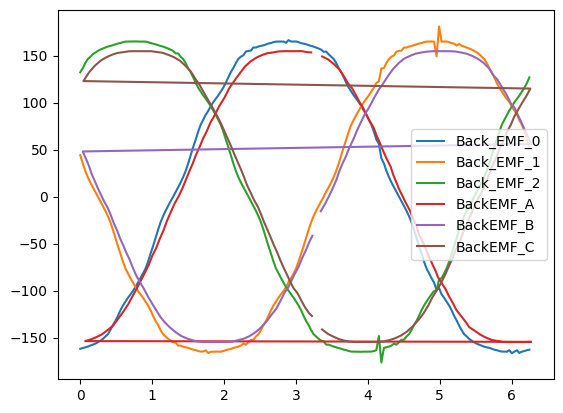

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(j1_df['angles'], j1_df['Back_EMF_0'], label='Back_EMF_0')
ax.plot(j1_df['angles'], j1_df['Back_EMF_1'], label='Back_EMF_1')
ax.plot(j1_df['angles'], j1_df['Back_EMF_2'], label='Back_EMF_2')
ax.plot((np.deg2rad(m1_op1_results['EMFa']['X'])*5 + offset) % (2*np.pi), m1_op1_results['EMFa']['Y'], label='BackEMF_A')
ax.plot((np.deg2rad(m1_op1_results['EMFb']['X'])*5 + offset) % (2*np.pi), m1_op1_results['EMFb']['Y'], label='BackEMF_B')
ax.plot((np.deg2rad(m1_op1_results['EMFc']['X'])*5 + offset) % (2*np.pi), m1_op1_results['EMFc']['Y'], label='BackEMF_C')
ax.legend()

In [52]:
# find the anqular offset between the two datasets
# convolution of 


In [36]:
j2_result = api.get_job(j2.id)
for artifact in j2_result['artifacts']:
    print(artifact['type'], artifact['url'], artifact['id'])
time.sleep(1)    

GMSH_MESH file://tae-cl00//app/job-data/65ef99c5602387385708f9a4/case.msh ee0143aea04de912042e1fdf
ELMER_SIF file://tae-cl00//app/job-data/65ef99c5602387385708f9a4/case.sif 328da06d79752bb66256535e
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65ef99c5602387385708f9a4/results/step_t0001.vtu 17d1b4b136d114a10f8e24df
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65ef99c5602387385708f9a4/results/step_t0180.vtu e7bd39246c0bfba9206dd2da
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65ef99c5602387385708f9a4/postprocess/FluxPlot.gif 7dc31a9c52ea00e30d59c0f8
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65ef99c5602387385708f9a4/postprocess/Torque.png 21ce110efd0682f0557b92b8
RESULT_PLOT file://tae-cl00//app/job-data/65ef99c5602387385708f9a4/postprocess/Currents.png 06dfa9b7de11e25681da1af6
RESULT_PLOT file://tae-cl00//app/job-data/65ef99c5602387385708f9a4/postprocess/FluxLinkage.png 0dc65ba93f9075fbd7

In [79]:
j2_result_data = [art for art in j2_result['artifacts'] if art['type']=='RESULT_DATA'][0]
j2_df = pd.read_csv(j2_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)

#load M1 results for the nominal operation point
#load M1 results for the nominal operation point
m1_op1_pv = pd.read_csv("M1/Nominal_24Nm_2060rpm/PhaseVoltage.csv", header=[0, 1])

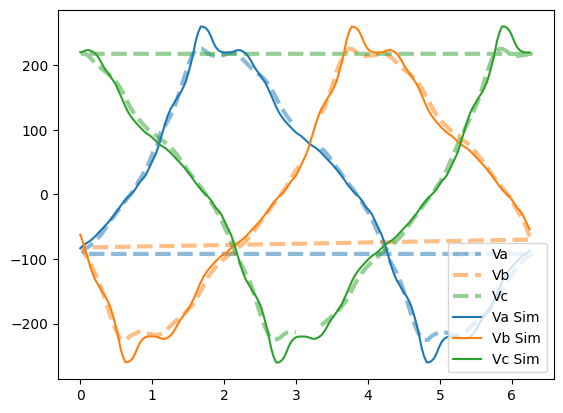

In [88]:
offset = np.pi *0.94
fig = plt.figure()
ax = fig.add_subplot(111)
l1, = ax.plot((np.deg2rad(m1_op1_pv['Va']['X'])*5 + offset) % (2*np.pi), m1_op1_pv['Va']['Y'], label='Va', 
              linewidth=3, linestyle='--', alpha=0.5)
l2, = ax.plot((np.deg2rad(m1_op1_pv['Vb']['X'])*5 + offset) % (2*np.pi), m1_op1_pv['Vb']['Y'], label='Vb',
              linewidth=3, linestyle='--', alpha=0.5)
l3, = ax.plot((np.deg2rad(m1_op1_pv['Vc']['X'])*5 + offset) % (2*np.pi), m1_op1_pv['Vc']['Y'], label='Vc',
              linewidth=3, linestyle='--', alpha=0.5)
ax.plot(j2_df['angles'], j2_df['Back_EMF_0'], label='Va Sim', color=l1.get_color())
ax.plot(j2_df['angles'], j2_df['Back_EMF_1'], label='Vb Sim', color=l2.get_color())
ax.plot(j2_df['angles'], j2_df['Back_EMF_2'], label='Vc Sim', color=l3.get_color())
ax.legend()

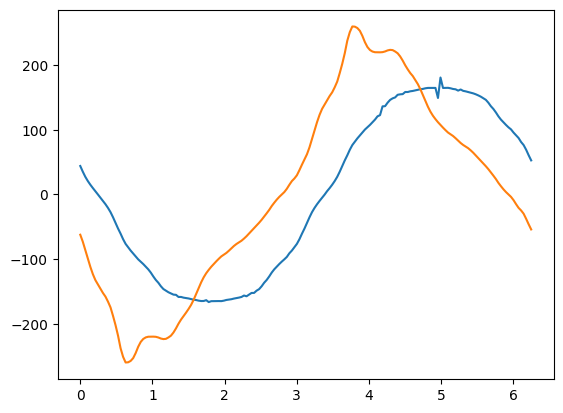

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(j1_df['angles'], j1_df['Back_EMF_1'], label='Back_EMF_1')
ax.plot(j2_df['angles'], j2_df['Back_EMF_1'], label='Back_EMF_1')

In [93]:
j2_df

,,Electromagnetic Field Energy,Fourier Loss Total,Fourier Loss 1,Fourier Loss 2,Air Gap Torque,Inertial Volume,Inertial Moment,angles,Scaled Torque,Back_EMF_0,Back_EMF_1,Back_EMF_2
0,0.0,106.2666352488,0.0,0.0,0.0,177.2481230809,0.0,0.0,0.000000,23.042256000517003,-83.249280,-62.271013,220.309081
1,0.0,106.3268325163,0.0,0.0,0.0,177.3549984253,0.0,0.0,0.034907,23.056149795289,-79.709320,-72.997451,221.351380
2,0.0,106.3988803685,0.0,0.0,0.0,177.7534197518,0.0,0.0,0.069813,23.107944567734,-76.600620,-85.959275,222.927021
3,0.0,106.4712554631,0.0,0.0,0.0,178.3706002441,0.0,0.0,0.104720,23.188178031733,-74.011803,-98.647175,223.678345
4,0.0,106.5405338861,0.0,0.0,0.0,179.041029951,0.0,0.0,0.139626,23.27533389363,-71.628529,-111.967423,223.167898
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.0,106.2439176036,0.0,0.0,0.0,180.547337387,0.0,0.0,6.108652,23.471153860310004,-99.400412,-24.703772,223.644467
176,0.0,106.2249393324,0.0,0.0,0.0,179.5536455147,0.0,0.0,6.143559,23.341973916911,-95.812046,-29.735319,221.230146
177,0.0,106.2178359541,0.0,0.0,0.0,178.6625468673,0.0,0.0,6.178466,23.226131092749,-93.109455,-37.647032,220.192573
178,0.0,106.2179009812,0.0,0.0,0.0,177.9358934231,0.0,0.0,6.213372,23.131666145003003,-90.415725,-46.099585,220.022881


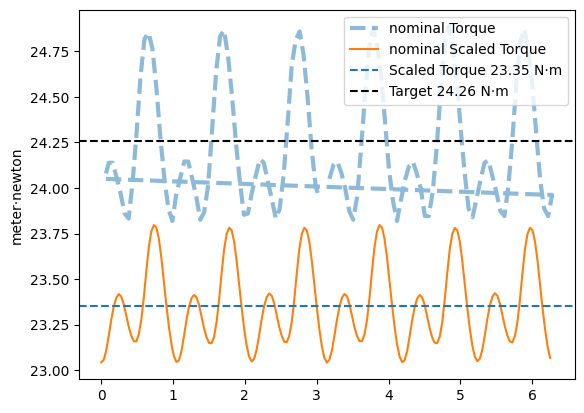

In [91]:

fig = plt.figure(2)
ax = fig.add_subplot(111)
l1, = ax.plot((np.deg2rad(m1_op1_tq['Torque']['X'])*5 + offset) % (2*np.pi), m1_op1_tq['Torque']['Y'], label='nominal Torque', 
              linewidth=3, linestyle='--', alpha=0.5)
l2, = ax.plot(j2_df['angles'], j2_df['Scaled Torque'], label='nominal Scaled Torque')
mean_torque = j2_df['Scaled Torque'].mean()
ax.axhline( mean_torque, label=f'Scaled Torque {mean_torque:2.4~P}', linestyle='--')
target_torque = 24.26 * q.N * q.m
ax.axhline( target_torque, label=f'Target {target_torque:2.4~P}', color='k', linestyle='--')

ax.legend()

In [ ]:
m1_df = pd.read_csv("Machine_Back_emfs_Machine_1.csv", skiprows=1, header=[0, 1], index_col=[0]).pint.quantify(level=-1)
m1_df.head()


In [ ]:
m1_df['Angles electrical'] = pint_pandas.PintArray(m1_df.index * m1.rotor['number_poles'] / 2, dtype="pint[degree]")
m1_df.dtypes

In [ ]:
fig = plt.figure(3)
ax = fig.add_subplot(111)
l1, = ax.plot(j1_df['angles'], -j1_df['Back_EMF_0'], label='Back_EMF_0', linestyle='--')
l2, = ax.plot(j1_df['angles'], -j1_df['Back_EMF_1'], label='Back_EMF_1', linestyle='--',)
l3, = ax.plot(j1_df['angles'], -j1_df['Back_EMF_2'], label='Back_EMF_2', linestyle='--')
ax.plot(m1_df['Angles electrical'].pint.to("radians"), m1_df['Phase A'], label='Phase A', color=l1.get_color())
ax.plot(m1_df['Angles electrical'].pint.to("radians"), m1_df['Phase B'], label='Phase B', color=l2.get_color())
ax.plot(m1_df['Angles electrical'].pint.to("radians"), m1_df['Phase C'], label='Phase C', color=l3.get_color())


In [ ]:
df_m1_phvol = pd.read_csv("m1_phase_voltage_nominal.csv",  header=[0, 1])
df_m1_phvol.head()

In [ ]:
from numpy import pi
fig = plt.figure()
ax = fig.add_subplot(111)
l1, =ax.plot(df_m1_phvol["Va"]["X"]*pi*5/180, -df_m1_phvol["Va"]["Y"],linestyle='--')
l2, =ax.plot(df_m1_phvol["Vb"]["X"]*pi*5/180, -df_m1_phvol["Vb"]["Y"],linestyle='--')
l3, =ax.plot(df_m1_phvol["Vc"]["X"]*pi*5/180, -df_m1_phvol["Vc"]["Y"],linestyle='--')
ax.plot(j2_df['angles'], j2_df['Back_EMF_0'], label='nominal Back_EMF_0', color=l1.get_color())
ax.plot(j2_df['angles'], j2_df['Back_EMF_1'], label='nominal Back_EMF_1', color=l2.get_color())
ax.plot(j2_df['angles'], j2_df['Back_EMF_2'], label='nominal Back_EMF_2', color=l3.get_color())
ax.legend()

In [ ]:
df_m1_phvol["Va"]["X"]*(pi*5/180)

In [ ]:
df_m1_torque = pd.read_csv("M1AverageTorqueNominal.csv", names=["Angles", "Torque"], header=0)
df_m1_torque.head()

In [ ]:
fig = plt.figure(2)
ax = fig.add_subplot(111)
l1, = ax.plot(j1_df['angles'], j1_df['Scaled Torque'], label='open cct Scaled Torque')
l2, = ax.plot(j2_df['angles'], j2_df['Scaled Torque'], label='nominal Scaled Torque')
mean_torque = j2_df['Scaled Torque'].mean()
ax.axhline( mean_torque, label=f'Scaled Torque {mean_torque:2.4~P}', linestyle='--')
target_torque = 24.26 * q.N * q.m
ax.axhline( target_torque, label=f'Target {target_torque:2.4~P}', color='k', linestyle='--')
ax.plot(df_m1_torque["Angles"]*pi*5/180, df_m1_torque["Torque"], label='nominal Torque')
ax.legend()